# Global indicator project - Phoenix, Arizona

## Pandana network accessibility - amenities pois
This notebook uses [pandana](https://udst.github.io/pandana/network.html) to calculate the distance from the orginal node of a sample point to the nearest pois (in this case, it is shop with supermarket and convenience stores). The accessibility score is integrated into the sample point dataframe based on the node id, the accessibility score is then transformed into a dummy variable with 1 as shops within 1600m of the original nodes of samples points, and 0 as shops beyond 1600m distance.

### Process:
1. Download or load points of interest (POIs) from OSM
2. Load the OSM graphml and create network via Pandana
3. Calculate accessibility to the amenity pois we retrieved from OSM.
    - the output results are the distance of orginal nodes to the nearest pois
4. Connect the accessibility score to sample point dataframe
    - accessibility score is calculated as 1=distance to the nearest pois are within 1600m; 0=distance to the nearest pois are beyond 1600m



In [12]:
from setup_local_analysis import *
from setup_OSMnetwork import *
from config import *

import pandana #pandana on python 3.6
from pandana.loaders import osm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pandana.__path__

['/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana']

In [2]:
# get bounding box from study region boundary shapefile
# get the 10 km buffered study region to consider the edge effects
bbox = get_bufferedstudyregion_bbox(boundary_filepath, crs=crs, to_crs=to_crs, to_latlong=True)

# check the shapefile format, study region boundary shapefile should specify lat lon geometry
# Bounding box should be formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
bbox = [bbox[1], bbox[0], bbox[3], bbox[2]]
print(bbox)

[32.414715167745996, -113.44197628074733, 34.13836571274371, -110.93231493458158]


## 1. Download points of interest (POIs) from OSM
What amenities are considered for daily living pois? - [OSMtag](https://taginfo.openstreetmap.org/keys/amenity): shop=supermarket, convenience

In [3]:
pois_df = get_osm_pois_gdf(poi_filepath=poi_filepath, shop=shop, bbox=bbox)
pois_df.head()

,shop,name,lat,lon,geometry
0,supermarket,Safeway,33.488551,-112.081794,POINT (-112.0817935 33.4885505)
1,convenience,Circle K,33.334805,-111.806096,POINT (-111.8060957 33.3348051)
2,convenience,7-Eleven,33.480013,-112.029747,POINT (-112.0297471 33.4800128)
3,supermarket,Basha's,33.333295,-111.912173,POINT (-111.9121727 33.3332955)
4,supermarket,Fry's Marketplace,33.321899,-111.930303,POINT (-111.9303033 33.3218992)


## 2. Load the OSM graphml and create network via Pandana

Reference:
[gdf node and edge attribute](https://automating-gis-processes.github.io/2018/notebooks/L6/network-analysis.html)  
[Pandana Network function](https://udst.github.io/pandana/tutorial.html)  
** Pandana is agnostic to the coordinate system. Use your local coordinate system or longitude then latitude - either one will work. (in this example, we use network graph with local coordinate system (lat-long))


In [4]:
network = get_pandana_network(G_filename=G_filename, folder=OSM_folder, bbox=bbox)

Network with 387,620 nodes loaded from graphml in 512.47 secs


## 3. Calculate accessibility to the amenity we retrieved

** make sure the loaded network is the same project as the pois dataframe

In [5]:
all_access = get_nearest_node_to_pois(pandana_network=network, pois_df=pois_df, distance=distance, num_pois=num_pois)

387,620 nodes in 84.44 secs


Ideas: for indicator calculation, we could count whether the nearest POIs are located within certain search distance to the nodes. (This approach use the hard distance thredshold approach)[https://3.basecamp.com/3662734/buckets/11779922/messages/1813713976 ]

### Plot accessibility from each node to any amenity

In [6]:
# keyword arguments to pass for the matplotlib figure
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10)}
# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}
# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'
# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}
# keyword arguments to pass to make the colorbar
cbar_kwargs = {}
# keyword arguments to pass to basemap
bmap_kwargs = {}
# color to make the background of the axis
bgcolor = 'k'

Text(0.5,1,"Walking distance (1600m) to ['supermarket', 'convenience'], phoenix")

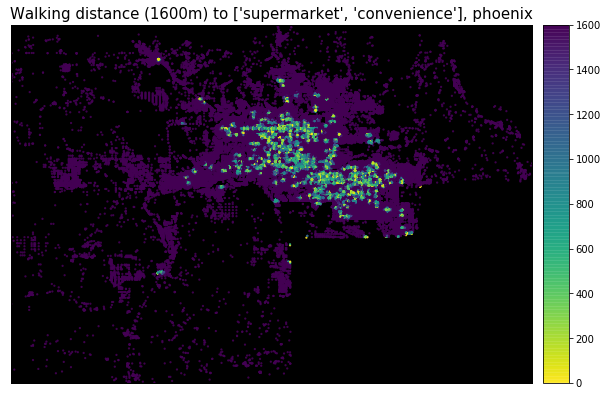

In [8]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance ({}m) to {}, {}'.format(distance, shop, placename), fontsize=15)
#fig.savefig('images/accessibility-shop-phx.png', dpi=200, bbox_inches='tight')

## 4. Integrate the accessibility score in sample point stats dataframe

In [ ]:
# load previously saved sample point dataframe
sample_points_stats = gpd.GeoDataFrame.from_file(samplepoint_stats_shapefile_path)

In [10]:
sample_points_df = add_access_score_to_df(all_access, sample_points_stats, distance=distance, col_name = 'Paces_shop')

In [11]:
# save sample point stats dataframe
ox.save_gdf_shapefile(sample_points_df, filename='{studyregion}_urban_sample_points_stats{suffix}'.format(
        studyregion = placename, suffix = suffix), folder=OSM_folder)